# This notebook walks through the creation of 1- and 2-D KDEs for orbit-fitting samples in 8 dimensions 

**Most of the code is necessary data processing/1-D KDE cursory creation, and under "Corner Plot Generation with KDEs" the corner plot sub-plots are individually generated with 1- and 2-D KDEs as shown in my presentation**

There are only 1000 posterior samples in this example to conform with GitHub file upload limits and increase computation. The code should be extensible up to ${\sim}10^{7}$ 8-dimensional samples.

In [1]:
# some plot setting
dpi=150 # plot dots per inch
lw=2 # plot lw
size_fac=5.25 # keeps plots scaled correctly
fftkde_res=2**20 # FFTKDE resolution for 1-D plots
hist_bins = 25 # for 1-D histograms behind 1-D KDEs


**Imports:**

In [2]:
import h5py # h5py
import numpy as np # numpy
import os # os
from multiprocessing import cpu_count, Pool # multiprocessing
import gc # garbage collection
import pandas as pd # pandas
from PIL import ImageColor # pillow
import cv2 # opencv
from tqdm import tqdm
from numba import jit, prange
import random
from numba_progress import ProgressBar

 # scipy
from scipy import stats
from scipy.integrate import simpson
from scipy import linalg as la

# astropy
from astropy.visualization import hist
import astropy.constants as c
import astropy.units as u

# uncertainties
from uncertainties import ufloat
from uncertainties.umath import *
import uncertainties.unumpy as unp

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.dpi'] = dpi
plt.rcParams['savefig.dpi'] = dpi
rc('text', usetex=True)
rc('font', size=12)
rc('legend', fontsize=12)
plt.rcParams['text.latex.preamble'] = r"""\usepackage{bm} \usepackage{amsmath} \usepackage{cmbright}
    \usepackage{siunitx} \usepackage{lmodern} \usepackage{sfmath} \sffamily \boldmath"""
from matplotlib import rcParams
import matplotlib.font_manager as font_manager
fontleg = font_manager.FontProperties(weight='bold') # bold legends
mpl.rcParams['xtick.major.pad'] = 14 * 1.5
mpl.rcParams['ytick.major.pad'] = 14 * 1.5

# orbitize, + my plotting code
import orbitize
from orbitize import read_input, priors, driver, system, sampler, results

# my functions!
from modified_plot import *
from fftkde_cred_int import *
from parallel_plots import generate_corner_plots

# KDEpy
from KDEpy import FFTKDE
from KDEpy.bw_selection import silvermans_rule, improved_sheather_jones

# Constants
PI = np.pi


**Fun colors:**

In [3]:
my_colors = ["#0d0887","#2c0594","#43039e","#5901a5","#6e00a8","#8305a7","#9511a1","#a72197",
          "#b6308b","#c5407e","#d14e72","#dd5e66","#e76e5b","#f07f4f","#f79044","#fca338",
          "#feb72d","#fccd25"]

# Configure matplotlib once
configure_matplotlib(dpi, size_fac)


In [4]:
def redistribute_rgb(r, g, b):
    threshold = 255.999
    m = max(r, g, b)
    if m <= threshold:
        return int(r), int(g), int(b)
    total = r + g + b
    if total >= 3 * threshold:
        return int(threshold), int(threshold), int(threshold)
    x = (3 * threshold - total) / (3 * m - total)
    gray = threshold - x * m
    return int(gray + x * r), int(gray + x * g), int(gray + x * b)

my_colors_rgb = np.array([mpl.colors.to_rgb(my_colors[i]) for i in range(len(my_colors))])

 # multiply to brighten
my_lighter_colors = np.array([my_colors_rgb[i] * 255 * np.logspace(np.log10(2.2), np.log10(1.0), len(my_colors))[i] for i in range(len(my_colors))])

# redistribute with function above to maintain hue
my_lighter_colors = np.array([redistribute_rgb(*my_lighter_colors[i])
                               for i in range(len(my_colors))])
my_lighter_colors = my_lighter_colors / 255


Now we have imported orbitize, and entered the name of our CSV data file containing relative astrometry for all of the relevant epochs

**System mass (by component and total)**

In [5]:
# both in solar masses
m_A = ufloat(1.22, 0.09)
m_B = ufloat(63, 3) * u.Mjup.to(u.Msun)

m_tot_prime = m_A + m_B
print(f"""Total mass of hii1348 with both uncertainties: {m_tot_prime} M_Sol""")
print()
print(f"""M_B = {m_B} M_Sol""")

m_tot_err = np.sqrt(m_A.s**2 + m_B.s**2)
print()
print(f"""Error on total mass of hii1348: {m_tot_err} M_sol""")

m_tot = m_A.n + m_B.n
print()
print(f"""Nominal total mass of hii1348: {m_tot} M_sol""")


Total mass of hii1348 with both uncertainties: 1.28+/-0.09 M_Sol

M_B = 0.0601+/-0.0029 M_Sol

Error on total mass of hii1348: 0.09004555098039961 M_sol

Nominal total mass of hii1348: 1.2801394367400674 M_sol


**orbitize! configuration used to generate the original samples (code not shown)**

In [6]:
path_to_file = 'hii1348b_orbitize_data.csv'
data = read_input.read_file(path_to_file)

In [7]:
num_secondary_bodies = 1

plx = 6.979
plx_err = 0.0305

myDriver = driver.Driver(
    path_to_file.format(orbitize.DATADIR),
    'OFTI',            # 'OFTI' or 'MCMC'
    num_secondary_bodies, # number of planets in the system (here, a star)
    m_tot_prime.n,     # Procyon A nominal mass
    plx,             # System parallax in mas from SIMBAD
    mass_err=m_tot_prime.s,    # Mass error
    plx_err=plx_err,     # Parallax error in mas from SIMBAD
    system_kwargs={
        "restrict_angle_ranges": True
    }
)

# system, parameter labels
sys = myDriver.system
lab = sys.param_idx

s = myDriver.sampler


Converting ra/dec data points in data_table to sep/pa. Original data are stored in input_table.


**Read-in Samples from .hdf5 file**

In [8]:
save_file = 'orbits_OFTI_1000_walkers0.hdf5'
sampler='OFTI'

hf = h5py.File(save_file, "r")  # Opens file for reading

# Load up each dataset from hdf5 file
sampler_name = str(hf.attrs["sampler_name"])
post = np.array(hf.get("post"))
lnlike = np.array(hf.get("lnlike"))
hf.close()  # Don't forget to close the file

orbits = np.copy(post)
# fractional height of value annotations
annotation_y_frac = 0.75

# orbits now has the orbital elements of each orbit
sma = orbits[:,0] # semi-major axis
ecc = orbits[:,1] # eccentricity
inc = orbits[:,2] * (180/PI) # inclination
omega = orbits[:,3] * (180/PI) # position angle of nodes
pan = orbits[:,4] * (180/PI) # position angle of nodes in rad
tau = orbits[:,5] # epoch of periastron passage
plx = orbits[:,6]
mtot = orbits[:,7]

# put these all into an array
adjusted_units_orbits = np.array([sma, ecc, inc, omega, pan, tau, plx, mtot])

# orbital period
period = np.sqrt(
    4 * np.pi**2.0 * (sma * u.AU)** 3 / (c.G * (mtot * u.Msun))
)
period = period.to(u.year).value


## Reported Values

## Mean and STDEV Values:

In [9]:
print('Mean +- STDEV Parameters fit by OFTI:')
print('----------------------------------------\n')
means_and_stds = []
for i,element_name in enumerate(lab.keys()):
    
    element = adjusted_units_orbits[i]
    element_mean = np.mean(element)
    element_std = np.std(element, ddof=1)
    
    print(f'{element_name} = {element_mean:.5f} +- {element_std:.5f}')
    means_and_stds.append(ufloat(element_mean, element_std))
    
means_and_stds = np.array(means_and_stds)


print('\n\nComputed parameters from some of the above fitted parameters:')
print('-------------------------------------------------------------\n')

# orbital period from Kepler's third law (not a fitted parameter directly)
period_mean = np.mean(period)
period_std = np.std(period, ddof=1)
print(f'period = {period_mean:.5f} +- {period_std:.5f}')# years



Mean +- STDEV Parameters fit by OFTI:
----------------------------------------

sma1 = 237.19112 +- 170.76434
ecc1 = 0.60291 +- 0.20792
inc1 = 130.87999 +- 17.13332
aop1 = 147.16434 +- 135.00318
pan1 = 129.16562 +- 38.72462
tau1 = 0.83383 +- 0.13398
plx = 6.97981 +- 0.03079
mtot = 1.28621 +- 0.08745


Computed parameters from some of the above fitted parameters:
-------------------------------------------------------------

period = 3687.02796 +- 6038.73535


## Med and MAD:

In [10]:
print('Median +- MAD Parameters fit by OFTI:')
print('----------------------------------------\n')
meds_and_mads = []
for i,element_name in enumerate(lab.keys()):
    
    element = adjusted_units_orbits[i]
    element_med = np.median(element)
    element_mad = stats.median_abs_deviation(element)
    
    print(f'{element_name} = {element_med:.5f} +- {element_mad:.5f}')
    meds_and_mads.append(ufloat(element_med, element_mad))
    
meds_and_mads = np.array(meds_and_mads)


print('\n\nComputed parameters from some of the above fitted parameters:')
print('-------------------------------------------------------------\n')

# orbital period from Kepler's third law (not a fitted parameter directly)
period_med = np.median(period)
period_mad = stats.median_abs_deviation(period)
print(f'period = {period_med:.5f} +- {period_mad:.5f}')# years


Median +- MAD Parameters fit by OFTI:
----------------------------------------

sma1 = 189.38958 +- 45.43010
ecc1 = 0.64344 +- 0.14367
inc1 = 128.50297 +- 12.59533
aop1 = 78.21505 +- 62.04987
pan1 = 140.33001 +- 14.11869
tau1 = 0.84690 +- 0.05063
plx = 6.97956 +- 0.02008
mtot = 1.28800 +- 0.06079


Computed parameters from some of the above fitted parameters:
-------------------------------------------------------------

period = 2330.88359 +- 824.97354


## Most Likely Orbit Values (not posterior):

In [11]:
max_log_like_post_i = np.where(lnlike == np.amax(lnlike))[0][0]
best_post = post[max_log_like_post_i].copy()
print(best_post)

best_post[2] *= 180 / np.pi # rad to deg inc
best_post[3] *= 180 / np.pi # rad to deg aop
best_post[4] *= 180 / np.pi # rad to deg pan

[176.54084528   0.46933201   2.1862785    0.40170023   2.50024063
   0.81111899   7.02839138   1.25514149]


In [12]:
best_sma = best_post[0] # semi-major axis
best_ecc = best_post[1] # eccentricity
best_inc = best_post[2] # inclination
best_omega = best_post[3] # argument of periastron
best_pan = best_post[4] # position angle of nodes in rad
best_tau = best_post[5] # epoch of periastron passage
best_plx = best_post[6] # parallax
best_mtot = best_post[7]# RV offset

print('Parameters fit by OFTI (parallax fixed):')
print('----------------------------------------\n')
# loop  through the best posterior elements (max. likelihood orbit)
for i,element_name in enumerate(lab.keys()):
    # find and print these best elements (adjusted for rad => degrees already)
    print(f'Max. log-likelihood orbit {element_name} = {best_post[i]:.5f}')

# computed:
#----------
# orbital period
best_period = np.sqrt(
    4 * np.pi**2.0 * (best_sma * u.AU)** 3 / (c.G * (best_mtot * u.Msun))
)
best_period = best_period.to(u.year).value

print('\n\nComputed parameters from some of the above fitted parameters:')
print('-------------------------------------------------------------\n')

# orbital period from Kepler's third law (not a fitted parameter directly)
print(f'Max. log-likelihood orbit period = {best_period:.5f}')# years


Parameters fit by OFTI (parallax fixed):
----------------------------------------

Max. log-likelihood orbit sma1 = 176.54085
Max. log-likelihood orbit ecc1 = 0.46933
Max. log-likelihood orbit inc1 = 125.26453
Max. log-likelihood orbit aop1 = 23.01573
Max. log-likelihood orbit pan1 = 143.25324
Max. log-likelihood orbit tau1 = 0.81112
Max. log-likelihood orbit plx = 7.02839
Max. log-likelihood orbit mtot = 1.25514


Computed parameters from some of the above fitted parameters:
-------------------------------------------------------------

Max. log-likelihood orbit period = 2093.77332


## Posterior Histograms/KDEs

In [13]:
param_list = np.array(list(lab.keys())) # all params

# dictionaries need filled for making a corner plot.
# each orbital parameter needs a value for each of these fftkde_plot parameters
dict_names = ['element_str', 'var', 'unit', 'xlabel', 'annotation_str', 'min', 'max', 'xlim', \
             'ann_x_frac', 'min_mirror', 'max_mirror', 'circ_param', 'fit_log', 'interp_pc', 'n_nom', \
             'n_errp', 'n_errm', 'ann_nom_add', 'peak']

empty_param_subdict = {param_list[i]:None for i in range(len(param_list))}

# keys are dict_names, values are empty_param_subdict for all
big_dict = {dict_name:empty_param_subdict for dict_name in dict_names}

# fill big_df like big_df.loc[param_lab] = list of fftkde_plot_params
big_df = pd.json_normalize([{'fftkde_plot_param': k, **v} for k, v in big_dict.items()])
big_df.set_index('fftkde_plot_param', inplace=True)
big_df = big_df.transpose() # flip rows and columns

big_df


fftkde_plot_param,element_str,var,unit,xlabel,annotation_str,min,max,xlim,ann_x_frac,min_mirror,max_mirror,circ_param,fit_log,interp_pc,n_nom,n_errp,n_errm,ann_nom_add,peak
sma1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
ecc1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
inc1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
aop1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
pan1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
tau1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
plx,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
mtot,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


## SMA

In [14]:
def sigfig_str(i, n):
    "Returns a string for number i with n sigfigs"
    
    return '{:g}'.format(float('{:.{p}g}'.format(i, p=n)))

In [15]:
# variable and units for the orbital element being plotted
sma_var = 'a'
sma_unit = 'au'
sma_lab = param_list[0]

# plot limits, labels, annotations, bins
sma_xlim = (75, 500) # range to plot on the x-axis (domain, I guess)
sma_xlabel = r'\textbf{$\bm{a}$ (au)}'
sma_annotation_str = r'$\mathbf{{\bm{{a}} = {:g} \substack{{+{:g} \\ \bm{{-}}{:g}}}}} \ \textbf{{au}}$'
sma_ann_nom_add=0
sma_ann_x_frac = 0.5
sma_bins = hist_bins

# 68% credible interval bounds in histogram indices (printed below!)
sma_i_bounds = (13, 62)

# histogram y-jumps
plot_sma_jump_hist = False
sma_jump_cut_frac = 0.005

# Gaussian fitting
fit_sma_peak = False
plot_sma_fit = False
cut_sma_fit_pc_l = 15
cut_sma_fit_pc_r = 25
cut_sma_fracs = (1 - cut_sma_fit_pc_l/100, 1 + cut_sma_fit_pc_r/100)

# new params for KDE
sma_min = 0; sma_max = np.inf
sma_min_mirror=True ; sma_max_mirror=False ; sma_circ_param=False
sma_fit_log=True ; sma_interp_pc=5. # default
sma_n_nom=2 ; sma_n_errp=2 ; sma_n_errm=2


KDEpy FFT Kernel Density Estimation with Improved Sheather-Jones BW (Gaussian kernel):

In [16]:
sma_params = ['sma', sma_var, sma_unit, sma_xlabel, sma_annotation_str, sma_min, sma_max, sma_xlim, \
             sma_ann_x_frac, sma_min_mirror, sma_max_mirror, sma_circ_param, sma_fit_log, sma_interp_pc, \
              sma_n_nom, sma_n_errp, sma_n_errm, sma_ann_nom_add, None]

# update row in dataframe for sma with the above parameters
big_df.loc[sma_lab] = sma_params


Make the KDE plot!

In [17]:
sma_peak, sma_errp, sma_errm = fftkde_plot(
    sma,
    sma_params,
    obj='hii1348b',
    sampler=sampler,
    color=my_colors[5], 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=True,
    save=True,
    size_fac=size_fac/1.5,
    fftkde_res=fftkde_res,
    lw=lw*0.75,
    plot_hist=True,
    hist_bins=hist_bins,
    annotate=True,
    fill_alpha=0.52,
    hist_color=my_lighter_colors[8],
    base_margin=0.52,
    show_ylabel=True,
    no_ticks=True,
    no_tick_labels=True
)

big_df.loc[sma_lab, 'peak'] = sma_peak
plt.close()
gc.collect()


Creating Plot for sma...
fitting log
Total Probability in bounds of: 68.0%
a = (149.1844 +85.5807 or -35.6918) au

saving figure...



0

## ECC:

User input

In [18]:
# variable and units for the orbital element being plotted
ecc_var = 'e'
ecc_unit = ''
ecc_lab = param_list[1]

# plot labels, annotations, limits, bins
ecc_xlabel = r'$\bm{e}$'
ecc_annotation_str =r'$\mathbf{{ \bm{{e}} = {:g} \substack{{+{:g} \\ \bm{{-}}{:g}}}}}$'
ecc_ann_nom_add=0
ecc_ann_x_frac = 0.05
ecc_xlim = (0, 1) # range to plot on the x-axis (domain, I guess)
ecc_bins = hist_bins

# 68% credible interval bounds in histogram indices (printed below!)
ecc_i_bounds = (122, 225)

# histogram y-jumps
plot_ecc_jump_hist = False
ecc_jump_cut_frac = 0.005

# Gaussian fitting
fit_ecc_peak = False
plot_ecc_fit = False
cut_ecc_fit_pc_l = 15
cut_ecc_fit_pc_r = 12
cut_ecc_fracs = (1 - cut_ecc_fit_pc_l/100, 1 + cut_ecc_fit_pc_r/100)

# new params for KDE
ecc_min = 0; ecc_max = 1
ecc_min_mirror=True ; ecc_max_mirror=True ; ecc_circ_param=False
ecc_fit_log=False ; ecc_n_errp=2 ; ecc_n_nom=2 ; ecc_n_errm=2
ecc_interp_pc=5.


plotting

In [19]:
ecc_params = ['ecc', ecc_var, ecc_unit, ecc_xlabel, ecc_annotation_str, ecc_min, ecc_max, ecc_xlim, \
             ecc_ann_x_frac, ecc_min_mirror, ecc_max_mirror, ecc_circ_param, ecc_fit_log, ecc_interp_pc, \
              ecc_n_nom, ecc_n_errp, ecc_n_errm, ecc_ann_nom_add, None]

# update row in dataframe for ecc with the above parameters
big_df.loc[ecc_lab] = ecc_params


Make the KDE plot!

In [20]:
ecc_peak, ecc_errp, ecc_errm = fftkde_plot(
    ecc,
    ecc_params,
    obj='hii1348b',
    sampler=sampler,
    color=my_colors[10], 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=True,
    save=True,
    size_fac=size_fac/1.5,
    fftkde_res=fftkde_res,
    lw=lw*0.75,
    plot_hist=True,
    hist_bins=hist_bins,
    annotate=True,
    fill_alpha=0.5,
    hist_color=my_lighter_colors[10],
    base_margin=0.52,
    show_ylabel=False,
    no_ticks=True,
    no_tick_labels=True,
    calc_kde=True
)

big_df.loc[ecc_lab, 'peak'] = ecc_peak
plt.close()
gc.collect()


Creating Plot for ecc...
Total Probability in bounds of: 68.0%
e = (0.7619 +0.1217 or -0.2596) 

saving figure...



0

## Inclination:

User input

In [21]:
# variable and units for the orbital element being plotted
inc_var = 'i'
inc_unit = 'deg'
inc_lab = param_list[2]

# plot labels, annotations, limits, bins
inc_xlabel = r'\textbf{$\bm{i}$ (\textdegree)}'
inc_annotation_str =r'$\mathbf{{\bm{{i}} = {:g}^\circ \substack{{+{:g}^\circ \\ \bm{{-}}{:g}^\circ}}}}$'
inc_ann_nom_add=0
inc_ann_x_frac = 0.6
inc_xlim = (90, 180) # range to plot on the x-axis (domain, I guess)
inc_bins = hist_bins

# 68% credible interval bounds in histogram indices (printed below!)
inc_i_bounds = (44, 138)

# histogram y-jumps
plot_inc_jump_hist = False
inc_jump_cut_frac = 0.005

# Gaussian fitting
fit_inc_peak = False
plot_inc_fit = False
cut_inc_fit_pc_l = 7
cut_inc_fit_pc_r = 14
cut_inc_fracs = (1 - cut_inc_fit_pc_l/100, 1 + cut_inc_fit_pc_r/100)

inc_min = 90 ; inc_max = 180 # deg
inc_min_mirror=True ; inc_max_mirror=True ; inc_circ_param=False
inc_fit_log=False ; inc_n_errp=2 ; inc_n_nom=3 ; inc_n_errm=1
inc_interp_pc=5.


plotting

In [22]:
inc_params = ['inc', inc_var, inc_unit, inc_xlabel, inc_annotation_str, inc_min, inc_max, inc_xlim, \
             inc_ann_x_frac, inc_min_mirror, inc_max_mirror, inc_circ_param, inc_fit_log, inc_interp_pc, \
              inc_n_nom, inc_n_errp, inc_n_errm, inc_ann_nom_add, None]

# update row in dataframe for inc with the above parameters
big_df.loc[inc_lab] = inc_params


Make the KDE plot!

In [23]:
fig, ax = plt.subplots(dpi=dpi, figsize=(10, 10))
inc_peak, inc_errp, inc_errm = fftkde_plot(
    inc,
    inc_params,
    obj='hii1348b',
    sampler=sampler,
    color=my_colors[14], 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=True,
    save=True,
    size_fac=size_fac/1.5,
    fftkde_res=fftkde_res,
    lw=lw*0.75,
    plot_hist=True,
    hist_bins=100,
    annotate=True,
    fill_alpha=0.5,
    hist_color=my_lighter_colors[17],
    base_margin=0.52,
    show_ylabel=False,
    no_ticks=True,
    no_tick_labels=True
)

big_df.loc[inc_lab, 'peak'] = inc_peak
plt.close()
gc.collect()


Creating Plot for inc...
Total Probability in bounds of: 68.0%
i = (117.5967 +23.3998 or -10.1142) deg

saving figure...



0

## Position Angle of Nodes ($\Omega$)

In [24]:
# variable and units for the orbital element being plotted
pan_var = 'pan'
pan_unit = 'deg'
pan_lab = param_list[4]

# plot labels, annotations, limits, bins
pan_xlabel = r'\textbf{$\boldsymbol{\Omega}$ (\textdegree)}'
pan_annotation_str =r'$\mathbf{{\boldsymbol{{\Omega = {:g}^\circ \substack{{+{:g}^\circ \\ \bm{{-}}{:g}^\circ}}}}}}$'
pan_ann_x_frac = 0.64
pan_xlim = (0, 180) # range to plot on the x-axis (domain, I guess)
pan_bins = hist_bins

# 68% credible interval bounds in histogram indices (printed below!)
pan_i_bounds = (5, 20)

# histogram y-jumps
plot_pan_jump_hist = False
pan_jump_cut_frac = 0.02

# Gaussian fitting
fit_pan_peak = False

if fit_pan_peak:
    plot_pan_fit = False
else:
    plot_pan_fit = False
    
cut_pan_fit_pc_l = 21
cut_pan_fit_pc_r = 25
cut_pan_fracs = (1 - cut_pan_fit_pc_l/100, 1 + cut_pan_fit_pc_r/100)

In [25]:
fig, ax = plt.subplots(dpi=dpi)

# make the hisogram
pany, panx, _ = hist(pan, density=True, histtype='stepfilled',
                       color=my_colors[10], bins=pan_bins, range=pan_xlim, alpha=1)

pan_bins = pany.size

# get the middle values of bins (x is the edges, 1 more index here than for y)
panx_mid = moving_average(panx, 2)

panpeak = pany.max() # peak in the element histogram
panmin = pany.min()

# find the peak in sma probability
panpeak_i = np.where(pany == panpeak)[0][0]
panpeak_x_mid = panx_mid[panpeak_i]

# find the peak in sma probability
panmin_i = np.where(pany == panmin)[0][0]
panmin_x_mid = panx_mid[panmin_i]

print(f'pan_bins: {pan_bins}')


plt.close()
gc.collect()


pan_bins: 25


4854

In [26]:
# A, mu, sigma, b, a for Gaussian + ax + b
pan_param_0 = [-9.40182357e-02,  1.26932128e+02,  6.21835314e+02, -7.94535678e-02,
        1.43308174e-03]
# Move everything past the minimum to a negative angle
modulo = 180
pan_wrapped2 = np.copy(pan)

# shift left or right depending on peak relative to minimum
if panmin_x_mid > panpeak_x_mid:
    pan_wrap_shift = modulo - panmin_x_mid
else:
    pan_wrap_shift = 0 - panmin_x_mid

pan_wrap_shift = int(np.round(pan_wrap_shift)) # nearest integer degree
pan_wrapped2 += pan_wrap_shift

print(f'\nWrap shift: {pan_wrap_shift} deg')
pan_ann_nom_add = -pan_wrap_shift

# anything that got shifted beyond modulo or left of 0 should be wrapped accordingly.
pan_wrapped2[pan_wrapped2 > modulo] -= modulo

# need to adjust omega for this shift as well!!!!
omega[pan_wrapped2 < 0] += 180

pan_wrapped2[pan_wrapped2 < 0] += modulo
adjusted_units_orbits[4] = pan_wrapped2# update arr of orbital params

# new xlabel for adjusted parameter
if pan_wrap_shift > 0:
    pan_wrapped2_xlabel = r'\textbf{{$\boldsymbol{{\Omega + {:.0f}^\circ \pmod{{180^\circ}}}}$}}'.format(pan_wrap_shift)
else:
    pan_wrapped2_xlabel = r'\textbf{{$\boldsymbol{{\Omega - {:.0f}^\circ \pmod{{180^\circ}}}}$}}'.format(np.abs(pan_wrap_shift))

try:
    pan_param
except NameError:
    
    pan_param = element_hist(pan_wrapped2, 'pan', pan_var, pan_unit, pan_wrapped2_xlabel,
                               pan_annotation_str, pan_i_bounds, bins=pan_bins, xlim=pan_xlim,
                               plot_jump_hist=plot_pan_jump_hist,
                             fit_peak=fit_pan_peak, plot_fit=plot_pan_fit, fit_cut_fracs=cut_pan_fracs,
                             ann_x_frac=pan_ann_x_frac, param=pan_param_0, color=my_colors[17],
                             jump_cut_frac=pan_jump_cut_frac,
                            obj='hii1348b', sampler='OFTI', alpha=1,
                            dpi=dpi, ann_nom_add=pan_ann_nom_add)

else:
    pan_param = element_hist(pan_wrapped2, 'pan', pan_var, pan_unit, pan_wrapped2_xlabel,
                           pan_annotation_str, pan_i_bounds, bins=pan_bins, xlim=pan_xlim,
                           plot_jump_hist=plot_pan_jump_hist,
                         fit_peak=fit_pan_peak, plot_fit=plot_pan_fit, fit_cut_fracs=cut_pan_fracs,
                         ann_x_frac=pan_ann_x_frac, param=pan_param, color=my_colors[17],
                         jump_cut_frac=pan_jump_cut_frac,
                        obj='hii1348b', sampler='OFTI', alpha=1,
                        dpi=dpi, ann_nom_add=pan_ann_nom_add)


print(repr(pan_param))
plt.close()
gc.collect()


Wrap shift: -40 deg
element: [102.30225284 124.39779846  83.19579527  86.38667632  62.11127844
  83.31584466 109.08249423 144.64529275  84.61164746 108.97911101
 105.47150393 104.51539572  79.4682243  114.59663127 108.29886118
 123.49921309  32.21682702 121.52265057  83.28037335 108.32589084
 103.84396845  97.61982881  54.39084025  24.36667082 173.21319196
 109.72163399 108.92995208  86.36092588  97.19551288  36.2464143
  95.34854256  96.13342857 117.29170599   4.45768114  55.59453557
 103.91943956  95.57023204  65.6101447   80.74436336 106.66939326
 142.97588344 114.49653029 119.72322694  66.65321581  94.46782399
 116.72652303  99.65407098  90.22131809 164.50872781 116.71393479
 114.28332018  95.84853032  95.48043616 127.27492083 127.67168885
  47.44256635  40.58782739  83.21140831 127.65901691 102.42368737
  89.85919013  91.90664773 105.61142759  26.81825385  94.28040095
  94.4498278  105.26679275 100.97128517  78.10148021  43.1781021
 109.93572497  84.95654129 105.17494531  48.6698

33

In [27]:
# deg, just for FFTKDE boundary condition (circular, in this case)
pan_min=0
pan_max=180
pan_min_mirror=False ; pan_max_mirror=False ; pan_circ_param=True
pan_fit_log=False ; pan_n_errp=2 ; pan_n_nom=3 ; pan_n_errm=2
pan_interp_pc=5.

pan_params = ['pan', pan_var, pan_unit, pan_wrapped2_xlabel, pan_annotation_str, pan_min, pan_max, pan_xlim, \
             pan_ann_x_frac, pan_min_mirror, pan_max_mirror, pan_circ_param, pan_fit_log, pan_interp_pc, \
              pan_n_nom, pan_n_errp, pan_n_errm, pan_ann_nom_add, None]

# update row in dataframe for pan with the above parameters
big_df.loc[pan_lab] = pan_params


Make the KDE plot!

In [28]:
pan_peak, pan_errp, pan_errm = fftkde_plot(
    pan_wrapped2,
    pan_params,
    obj='hii1348b',
    sampler=sampler,
    color=my_colors[10], 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=True,
    size_fac=size_fac,
    fftkde_res=fftkde_res,
    lw=lw
)

big_df.loc[pan_lab, 'peak'] = pan_peak
plt.close()
gc.collect()


Creating Plot for pan...
Total Probability in bounds of: 68.0%
pan = (104.8174 +20.1179 or -23.6921) deg

saving figure...



0

## Argument of Periastron $\mathbf{(\boldsymbol{\omega})}$

In [29]:
# variable and units for the orbital element being plotted
omega_var = 'omega'
omega_unit = 'deg'
omega_lab = param_list[3]

# plot labels, annotations, limits, bins
omega_xlabel = r'\textbf{$\boldsymbol{\omega}$ (\textdegree)}'
omega_annotation_str =r'$\mathbf{{\boldsymbol{{\omega = {:g}^\circ \substack{{+{:g}^\circ \\ \bm{{-}}{:g}^\circ}}}}}}$'
omega_ann_x_frac = 0.65
omega_xlim = (0, 360) # range to plot on the x-axis (domain, I guess)
omega_bins = hist_bins

# 68% credible interval bounds in histogram indices (printed below!)
omega_i_bounds = (5, 20)

# histogram y-jumps
plot_omega_jump_hist = False
omega_jump_cut_frac = 0.005

# Gaussian fitting
fit_omega_peak = False

if fit_omega_peak:
    plot_omega_fit = False
else:
    plot_omega_fit = False
    
cut_omega_fit_pc_l = 34
cut_omega_fit_pc_r = 34
cut_omega_fracs = (1 - cut_omega_fit_pc_l/100, 1 + cut_omega_fit_pc_r/100)


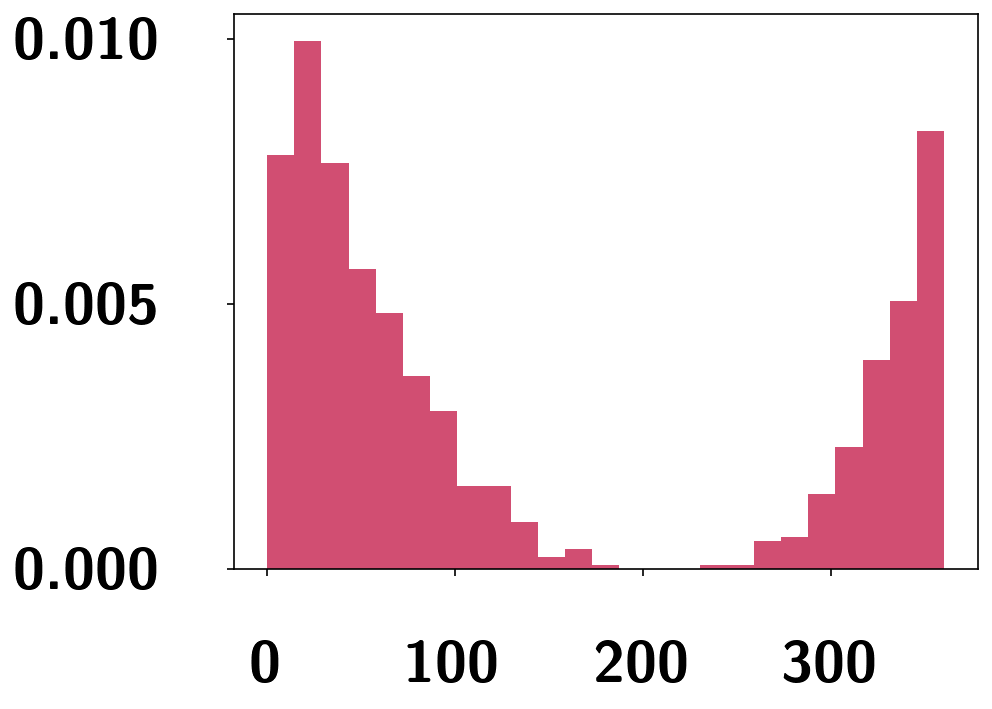

In [30]:
fig, ax = plt.subplots(dpi=dpi)

# make the hisogram
omegay, omegax, _ = hist(omega, density=True, histtype='stepfilled',
                       color=my_colors[10], bins=omega_bins, range=omega_xlim, alpha=1)

omega_bins = omegay.size
# get the middle values of bins (x is the edges, 1 more index here than for y)
omegax_mid = moving_average(omegax, 2)

omegapeak = omegay.max() # peak in the element histogram
omegamin = omegay.min()

# find the peak in sma probability
omegapeak_i = np.where(omegay == omegapeak)[0][0]
omegapeak_x_mid = omegax_mid[omegapeak_i]

# find the peak in sma probability
omegamin_i = np.where(omegay == omegamin)[0][0]
omegamin_x_mid = omegax_mid[omegamin_i]

# plt.close()
# gc.collect()

plt.show()


In [31]:
# A, mu, sigma, b, a for Gaussian + ax + b
omega_param_0 = [-2.45204396e-02,  5.31679640e+01,  2.70393346e+03,  2.61792176e-02,
       -9.95688208e-05]

# Move everything past the minimum to a negative angle
omega_wrapped2 = np.copy(omega)
omega_wrap_shift = 360 - omegamin_x_mid
omega_wrap_shift = np.round(omega_wrap_shift) # nearest integer degree
omega_wrapped2 += omega_wrap_shift

print(f'\nWrap shift: {omega_wrap_shift} deg')
omega_ann_nom_add = -omega_wrap_shift

omega_wrapped2[omega_wrapped2 > 360] -= 360
adjusted_units_orbits[3] = omega_wrapped2# update arr of orbital params

# new xlabel for adjusted parameter
if omega_wrap_shift > 0:
    omega_wrapped2_xlabel = r'\textbf{{$\boldsymbol{{\omega + {:.0f}^\circ \pmod{{360^\circ}}}}$}}'.format(omega_wrap_shift)
else:
    omega_wrapped2_xlabel = r'\textbf{{$\boldsymbol{{\omega - {:.0f}^\circ \pmod{{360^\circ}}}}$}}'.format(np.abs(omega_wrap_shift))

try:
    omega_param
except NameError:
    
    omega_param = element_hist(omega_wrapped2, 'omega', omega_var, omega_unit, omega_wrapped2_xlabel,
                               omega_annotation_str, omega_i_bounds, bins=omega_bins, xlim=(0,360),
                               plot_jump_hist=plot_omega_jump_hist,
                             fit_peak=fit_omega_peak, plot_fit=plot_omega_fit, fit_cut_fracs=cut_omega_fracs,
                             ann_x_frac=omega_ann_x_frac, param=omega_param_0, color=my_colors[8],
                             jump_cut_frac=omega_jump_cut_frac,
                            obj='hii1348b', sampler='OFTI', alpha=0.9,
                            dpi=dpi, ann_nom_add=omega_ann_nom_add)

else:
    omega_param = element_hist(omega_wrapped2, 'omega', omega_var, omega_unit, omega_wrapped2_xlabel,
                           omega_annotation_str, omega_i_bounds, bins=omega_bins, xlim=(0,360),
                           plot_jump_hist=plot_omega_jump_hist,
                         fit_peak=fit_omega_peak, plot_fit=plot_omega_fit, fit_cut_fracs=cut_omega_fracs,
                         ann_x_frac=omega_ann_x_frac, param=omega_param, color=my_colors[8],
                         jump_cut_frac=omega_jump_cut_frac,
                        obj='hii1348b', sampler='OFTI', alpha=0.9,
                        dpi=dpi, ann_nom_add=omega_ann_nom_add)


print(repr(omega_param))

plt.close()
gc.collect()


Wrap shift: 166.0 deg
element: [232.68423678 243.68590843 168.25448677 150.93219819 125.99293932
 167.91726674 162.8155492  222.06772792 186.66623127 310.01047579
 235.68783312 189.40830253 151.47823286 222.08824962 181.20211023
 221.49366075  94.58563807 227.477871   141.38399297 170.42320747
 162.23099511 181.76549326 126.76901911  96.1235028  267.11998196
 185.34043362 184.83030753 227.71883671 187.69482513 121.56085457
 154.61759016 297.44922768 255.72538011  82.86650275 132.186778
 159.42595139 203.14759435 138.44046209 138.91440046 220.74135245
 211.26674592 218.18849667 190.62747577 135.67683543 165.64476333
 186.46305591 185.23258664 142.25630693 233.91957159 211.43887901
 199.53709095 206.27243468 151.4947346  264.73404071 249.3835271
 116.85192082 120.60813504 178.69258733 192.14928779 234.06096235
 151.88989133 142.1797696  168.00017064  92.29562885 150.21380606
 183.26300408 167.98617621 161.94840884 206.64942531 129.83861713
 207.37584925 169.5303317  278.15331262 109.208

4310

In [32]:
# deg, just for FFTKDE boundary condition (circular, in this case)
omega_min=0
omega_max=360
omega_min_mirror=False ; omega_max_mirror=False ; omega_circ_param=True
omega_fit_log=False ; omega_n_errp=2 ; omega_n_nom=2 ; omega_n_errm=2
omega_interp_pc=5.

omega_params = ['omega', omega_var, omega_unit, omega_wrapped2_xlabel, omega_annotation_str, omega_min, omega_max, omega_xlim, \
             omega_ann_x_frac, omega_min_mirror, omega_max_mirror, omega_circ_param, omega_fit_log, omega_interp_pc, \
              omega_n_nom, omega_n_errp, omega_n_errm, omega_ann_nom_add, None]

# update row in dataframe for omega with the above parameters
big_df.loc[omega_lab] = omega_params


In [33]:
omega_peak, omega_errp, omega_errm = fftkde_plot(
    omega_wrapped2,
    omega_params,
    obj='hii1348b',
    sampler=sampler,
    color=my_colors[10], 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=True,
    size_fac=size_fac,
    fftkde_res=fftkde_res,
    lw=lw
)

big_df.loc[omega_lab, 'peak'] = omega_peak
plt.close()
gc.collect()


Creating Plot for omega...
Total Probability in bounds of: 68.0%
omega = (184.3029 +53.5857 or -43.1789) deg

saving figure...



0

## Epoch of periastron $\mathbf{(\tau)}$

In [34]:
# variable and units for the orbital element being plotted
tau_var = 'tau'
tau_unit = ''
tau_lab = param_list[5]

# plot labels, annotations, limits, bins
tau_xlabel = r'$\boldsymbol{\tau}$'
tau_annotation_str =r'$\mathbf{{\boldsymbol{{\tau}} = {:g} \substack{{+{:g} \\ \bm{{-}}{:g}}}}}$'
tau_ann_x_frac = 0.07
tau_xlim = (0.3, 0.7) # range to plot on the x-axis (domain, I guess)
tau_bins = hist_bins

# 68% credible interval bounds in histogram indices (printed below!)
tau_i_bounds = (5, 20)

# histogram y-jumps
plot_tau_jump_hist = False
tau_jump_cut_frac = 0.04

# Gaussian fitting
fit_tau_peak = False

if fit_tau_peak:
    plot_tau_fit = False
else:
    plot_tau_fit = False
    
cut_tau_fit_pc_l = 33
cut_tau_fit_pc_r = 10
cut_tau_fracs = (1 - cut_tau_fit_pc_l/100, 1 - cut_tau_fit_pc_r/100)


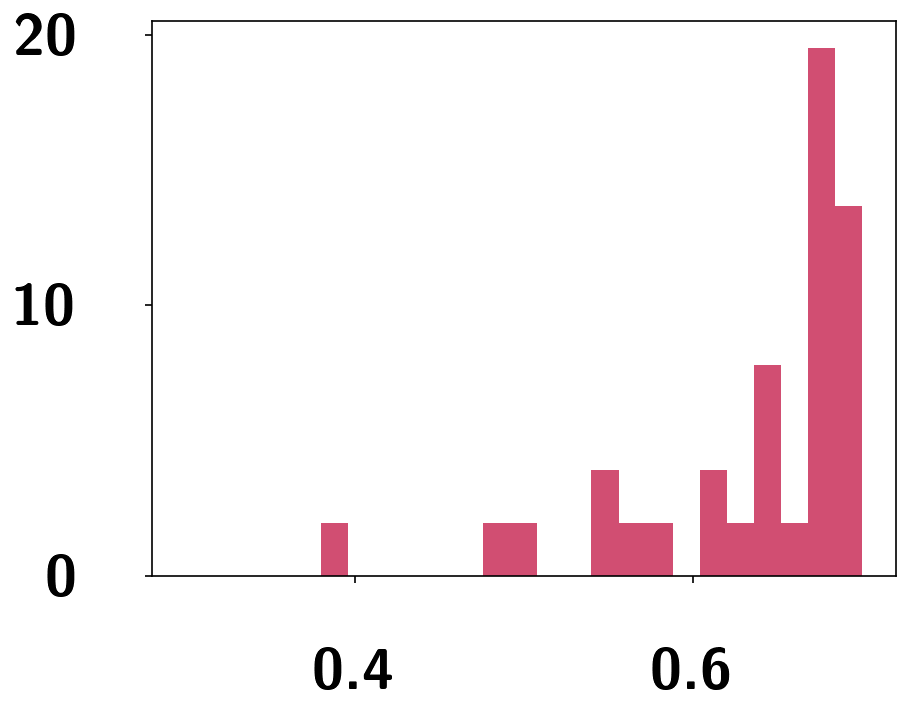

5002

In [35]:
fig, ax = plt.subplots(dpi=dpi)

# make the hisogram
tauy, taux, _ = hist(tau, density=True, histtype='stepfilled',
                       color=my_colors[10], bins=tau_bins, range=tau_xlim, alpha=1)

# get the middle values of bins (x is the edges, 1 more index here than for y)
taux_mid = moving_average(taux, 2)

taupeak = tauy.max() # peak in the element histogram
taumin = tauy.min()

# find the peak in sma probability
taupeak_i = np.where(tauy == taupeak)[0][0]
taupeak_x_mid = taux_mid[taupeak_i]

# find the peak in sma probability
taumin_i = np.where(tauy == taumin)[0][0]
taumin_x_mid = taux_mid[taumin_i]
plt.show()
gc.collect()


In [36]:
# A, mu, sigma, b, a for Gaussian + ax + b
tau_param_0 = [ 1.46994839e+03, -6.45566469e-02,  4.47573870e-01, -1.67828922e+03,
        1.30627439e+03]
# Move everything past the minimum to a negative angle
modulo = 1
tau_wrapped2 = np.copy(tau)

# shift left or right depending on peak relative to minimum
if taumin_x_mid > taupeak_x_mid:
    tau_wrap_shift = modulo - taumin_x_mid
else:
    tau_wrap_shift = 0 - taumin_x_mid
    
tau_wrapped2 += tau_wrap_shift

print(f'\nWrap shift: {tau_wrap_shift}')
tau_ann_nom_add = -tau_wrap_shift

# anything that got shifted beyond modulo or left of 0 should be wrapped accordingly.
tau_wrapped2[tau_wrapped2 > modulo] -= modulo
tau_wrapped2[tau_wrapped2 < 0] += modulo
adjusted_units_orbits[5] = tau_wrapped2# update arr of orbital params

# new xlabel for adjusted parameter
if tau_wrap_shift > 0:
    tau_wrapped2_xlabel = r'\textbf{{$\boldsymbol{{\tau}} + {:.3f} \pmod{{1}}$}}'.format(tau_wrap_shift)
else:
    tau_wrapped2_xlabel = r'\textbf{{$\boldsymbol{{\tau}} - {:.3f} \pmod{{1}}$}}'.format(np.abs(tau_wrap_shift))

try:
    tau_param
except NameError:
    
    tau_param = element_hist(tau_wrapped2, 'tau', tau_var, tau_unit, tau_wrapped2_xlabel,
                               tau_annotation_str, tau_i_bounds, bins=tau_bins, xlim=tau_xlim,
                               plot_jump_hist=plot_tau_jump_hist,
                             fit_peak=fit_tau_peak, plot_fit=plot_tau_fit, fit_cut_fracs=cut_tau_fracs,
                             ann_x_frac=tau_ann_x_frac, param=tau_param_0, color=my_colors[14],
                             jump_cut_frac=tau_jump_cut_frac,
                            obj='hii1348b', sampler='OFTI', alpha=1,
                            dpi=dpi, ann_nom_add=tau_ann_nom_add)

else:
    tau_param = element_hist(tau_wrapped2, 'tau', tau_var, tau_unit, tau_wrapped2_xlabel,
                           tau_annotation_str, tau_i_bounds, bins=tau_bins, xlim=tau_xlim,
                           plot_jump_hist=plot_tau_jump_hist,
                         fit_peak=fit_tau_peak, plot_fit=plot_tau_fit, fit_cut_fracs=cut_tau_fracs,
                         ann_x_frac=tau_ann_x_frac, param=tau_param, color=my_colors[14],
                         jump_cut_frac=tau_jump_cut_frac,
                        obj='hii1348b', sampler='OFTI', alpha=1,
                        dpi=dpi, ann_nom_add=tau_ann_nom_add)


print(repr(tau_param))

plt.close()
gc.collect()


Wrap shift: -0.308
element: [0.60370614 0.61218626 0.49042279 0.42886789 0.5010497  0.5650831
 0.36410111 0.59236691 0.59917619 0.69404529 0.61532472 0.48986558
 0.49757856 0.53886121 0.43061105 0.54040344 0.50033724 0.58462848
 0.47829415 0.50612214 0.39823337 0.52174611 0.5947327  0.56364507
 0.52076214 0.50998281 0.44433875 0.65325629 0.53619263 0.65287905
 0.55589674 0.70637148 0.62449433 0.61720081 0.66261123 0.42503832
 0.52858948 0.54548233 0.40229446 0.52772225 0.5007625  0.51698211
 0.54145595 0.5273324  0.55808428 0.39097003 0.47001474 0.43680368
 0.49224786 0.53759368 0.43747909 0.53964847 0.49105431 0.6630475
 0.58837483 0.53277957 0.6088718  0.59960917 0.51798201 0.56831972
 0.49258729 0.48111762 0.40197765 0.50237528 0.37730179 0.58045159
 0.48809793 0.45911059 0.56735288 0.58592817 0.52707853 0.57872741
 0.64200652 0.50587725 0.70203051 0.50584505 0.65035158 0.59245635
 0.54213808 0.36820883 0.47378998 0.52124174 0.60917355 0.53596685
 0.47312458 0.48518389 0.55089432 0

39

In [37]:
# deg, just for FFTKDE boundary condition (circular, in this case)
tau_min=0.
tau_max=1.
tau_min_mirror=True ; tau_max_mirror=True ; tau_circ_param=False
tau_fit_log=False ; tau_n_errp=2 ; tau_n_nom=2 ; tau_n_errm=1
tau_interp_pc=5.

tau_params = ['tau', tau_var, tau_unit, tau_wrapped2_xlabel, tau_annotation_str, tau_min, tau_max, tau_xlim, \
             tau_ann_x_frac, tau_min_mirror, tau_max_mirror, tau_circ_param, tau_fit_log, tau_interp_pc, \
              tau_n_nom, tau_n_errp, tau_n_errm, tau_ann_nom_add, None]

# update row in dataframe for tau with the above parameters
big_df.loc[tau_lab] = tau_params


Make the KDE plot!

In [38]:
tau_peak, tau_errp, tau_errm = fftkde_plot(
    tau_wrapped2,
    tau_params,
    obj='hii1348b',
    sampler=sampler,
    color=my_colors[10], 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=True,
    size_fac=size_fac,
    fftkde_res=fftkde_res,
    lw=lw
)

big_df.loc[tau_lab, 'peak'] = tau_peak
plt.close()
gc.collect()


Creating Plot for tau...
Total Probability in bounds of: 68.0%
tau = (0.5241 +0.0892 or -0.0621) 

saving figure...



0

# Parallax $\pi$

In [39]:
# variable and units for the orbital element being plotted
plx_var = 'pi'
plx_unit = 'mas'
plx_lab = param_list[6]

# plot labels, annotations, limits, bins
plx_xlabel = r'\textbf{$\boldsymbol{\pi}$ (mas)}'
plx_annotation_str = r'$\mathbf{{ \boldsymbol{{\pi}} = {:g} \substack{{+{:g} \\ \bm{{-}}{:g}}}}}$ \textbf{{mas}}'
plx_ann_nom_add=0
plx_ann_x_frac = 0.025
plx_xlim = np.array([6.875, 7.075])# + np.array([-1*((7.1-6.85)/2), ((7.1-6.85)/2)]) # range to plot on the x-axis (domain, I guess)
plx_bins = hist_bins

# 68% credible interval bounds in histogram indices (printed below!)
plx_i_bounds = (5, 20)

# histogram y-jumps
plot_plx_jump_hist = False
plx_jump_cut_frac = 0.08

# Gaussian fitting
fit_plx_peak = False

if fit_plx_peak:
    plot_plx_fit = False
else:
    plot_plx_fit = False
    
cut_plx_fit_pc_l = 1.1
cut_plx_fit_pc_r = 1.2
cut_plx_fracs = (1 - cut_plx_fit_pc_l/100, 1 + cut_plx_fit_pc_r/100)


In [40]:
# A, mu, sigma, b, a for Gaussian + ax + b
plx_param_0 = [1.30738883e+01,  6.97934077e+00,  1.00744775e-03,  3.54156245e+00,
       -5.39921269e-01]

try:
    plx_param
    
except NameError:
    
    plx_param = element_hist(plx, 'i', plx_var, plx_unit, plx_xlabel, plx_annotation_str,
                             plx_i_bounds, bins=plx_bins, xlim=plx_xlim, plot_jump_hist=plot_plx_jump_hist,
                             fit_peak=fit_plx_peak, plot_fit=plot_plx_fit, fit_cut_fracs=cut_plx_fracs,
                             ann_x_frac=plx_ann_x_frac, param=plx_param_0, color=my_colors[9],
                             jump_cut_frac=plx_jump_cut_frac,
                            obj='hii1348b', sampler='OFTI', alpha=0.8,
                            dpi=dpi)
else:

    plx_param = element_hist(plx, 'i', plx_var, plx_unit, plx_xlabel, plx_annotation_str,
                             plx_i_bounds, bins=plx_bins, xlim=plx_xlim, plot_jump_hist=plot_plx_jump_hist,
                             fit_peak=fit_plx_peak, plot_fit=plot_plx_fit, fit_cut_fracs=cut_plx_fracs,
                             ann_x_frac=plx_ann_x_frac, param=plx_param, color=my_colors[9],
                             jump_cut_frac=plx_jump_cut_frac,
                            obj='hii1348b', sampler='OFTI', alpha=0.8,
                            dpi=dpi)
        
print(repr(plx_param))
plt.close()
gc.collect()


element: [6.95707651 6.94034986 6.96351166 7.01126133 7.01807338 7.01713788
 6.9679575  6.96462825 7.00172806 6.97210693 6.99510286 6.94855579
 6.98504682 6.97533769 7.05399239 7.00646303 6.91732175 7.01671794
 6.97904906 6.94742746 7.02437872 6.98040288 6.98874453 6.97185091
 6.99856872 6.9851606  6.98277678 6.956059   7.00494975 6.96862937
 6.9820346  6.94018955 7.0481283  7.00480422 6.92975252 6.96305101
 6.99611616 6.95771997 6.97487752 7.02364241 7.00204492 6.99912583
 6.96217113 6.97439351 6.96332611 6.990439   6.95379792 6.99553423
 7.0144276  6.96649501 6.99352492 6.99019842 6.99281761 6.99840179
 6.97689486 6.93288053 6.97301961 7.01175968 6.95795181 6.95641879
 6.98906262 7.04917346 6.99812564 6.96162282 6.944653   7.00332762
 6.95332931 6.98833391 7.00170542 6.92981308 6.99648527 6.9656287
 6.9102231  6.92256087 6.95835324 6.99401429 6.9148314  7.03750937
 6.98765376 6.97309502 6.97716948 6.94334234 6.96099598 7.01094284
 6.96457731 6.99759789 6.95996208 6.95821747 6.9341919

2623

In [41]:
# deg, just for FFTKDE boundary condition
# I'm using +- 4 sigma (larger of asymmetric errors)
plx_min=6.8265
plx_max=7.1225
plx_min_mirror=False ; plx_max_mirror=False ; plx_circ_param=False
plx_fit_log=False ; plx_n_errp=2 ; plx_n_nom=4 ; plx_n_errm=2
plx_interp_pc=0.5

plx_params = ['plx', plx_var, plx_unit, plx_xlabel, plx_annotation_str, plx_min, plx_max, plx_xlim, \
             plx_ann_x_frac, plx_min_mirror, plx_max_mirror, plx_circ_param, plx_fit_log, plx_interp_pc, \
              plx_n_nom, plx_n_errp, plx_n_errm, plx_ann_nom_add, None]

# update row in dataframe for plx with the above parameters
big_df.loc[plx_lab] = plx_params


Make the KDE plot!

In [42]:
plx_peak, plx_errp, plx_errm = fftkde_plot(
    plx,
    plx_params,
    obj='hii1348b',
    sampler=sampler,
    color=my_colors[10], 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=True,
    size_fac=size_fac,
    fftkde_res=fftkde_res,
    lw=lw
)

big_df.loc[plx_lab, 'peak'] = plx_peak
plt.close()
gc.collect()


Creating Plot for plx...
Total Probability in bounds of: 68.0%
pi = (6.9756 +0.0342 or -0.0228) mas

saving figure...



0

# Total Mass $M_\mathrm{tot}$

In [43]:
# variable and units for the orbital element being plotted
mtot_var = 'Mtot'
mtot_unit = 'M_Sun'
mtot_lab = param_list[7]

# plot labels, annotations, limits, bins
mtot_xlabel = r'\textbf{$\mathrm{M_\text{tot}}$ ($\mathrm{M}_\mathbf{\odot}$)}'
mtot_annotation_str = r'\textbf{{$\mathbf{{ \mathrm{{\mathbf{{M_\text{{\textbf{{tot}}}}}}}} = {:g} \substack{{+{:g} \\ \bm{{-}}{:g} }} }} \ \mathrm{{M_\odot}}$}}'
mtot_ann_nom_add = 0
mtot_ann_x_frac = 0.66
mtot_xlim = (1.05, 1.55) # range to plot on the x-axis (domain, I guess)
mtot_bins = hist_bins

# 68% credible interval bounds in histogram indices (printed below!)
mtot_i_bounds = (5, 20)

# histogram y-jumps
plot_mtot_jump_hist = False
mtot_jump_cut_frac = 0.01

# Gaussian fitting
fit_mtot_peak = False

if fit_mtot_peak:
    plot_mtot_fit = False
else:
    plot_mtot_fit = False
    
cut_mtot_fit_pc_l = 20
cut_mtot_fit_pc_r = 17
cut_mtot_fracs = (1 - cut_mtot_fit_pc_l/100, 1 + cut_mtot_fit_pc_r/100)

In [44]:
# A, mu, var, b, a for Gaussian + ax + b
mtot_param_0 = [ 4.44423254,  1.28830709,  0.00781643,  0.16844715, -0.10805732]

# fit_x = np.linspace(*mtot_xlim, 1_000)
# plt.plot(fit_x, gaussian(fit_x, *mtot_param_0))

try:
    mtot_param
    
except NameError:
    
    mtot_param = element_hist(mtot, 'i', mtot_var, mtot_unit, mtot_xlabel, mtot_annotation_str,
                             mtot_i_bounds, bins=mtot_bins, xlim=mtot_xlim, plot_jump_hist=plot_mtot_jump_hist,
                             fit_peak=fit_mtot_peak, plot_fit=plot_mtot_fit, fit_cut_fracs=cut_mtot_fracs,
                             ann_x_frac=mtot_ann_x_frac, param=mtot_param_0, color=my_colors[9],
                             jump_cut_frac=mtot_jump_cut_frac,
                            obj='hii1348b', sampler='OFTI', alpha=0.8,
                            dpi=dpi)
else:

    mtot_param = element_hist(mtot, 'i', mtot_var, mtot_unit, mtot_xlabel, mtot_annotation_str,
                             mtot_i_bounds, bins=mtot_bins, xlim=mtot_xlim, plot_jump_hist=plot_mtot_jump_hist,
                             fit_peak=fit_mtot_peak, plot_fit=plot_mtot_fit, fit_cut_fracs=cut_mtot_fracs,
                             ann_x_frac=mtot_ann_x_frac, param=mtot_param, color=my_colors[16],
                             jump_cut_frac=mtot_jump_cut_frac,
                            obj='hii1348b', sampler='OFTI', alpha=0.8,
                            dpi=dpi)
        
print(repr(mtot_param))
plt.close()
gc.collect()

element: [1.15241476 1.33661024 1.34399852 1.24199514 1.35134157 1.35512288
 1.35746909 1.12236456 1.26315369 1.38308432 1.24369809 1.20642663
 1.13340645 1.1117928  1.35113544 1.40368983 1.28304818 1.22467781
 1.22575041 1.30112229 1.39604005 1.48486162 1.26178134 1.28113063
 1.29362305 1.37009836 1.24781728 1.27804391 1.21753941 1.30168174
 1.19867894 1.41221639 1.12597824 1.23814869 1.35643138 1.34030881
 1.23507462 1.44769681 1.3061281  1.22367642 1.23459912 1.3625717
 1.3862182  1.18214205 1.22167678 1.35223661 1.45208863 1.21970862
 1.25666259 1.30868071 1.35319778 1.18371641 1.20190923 1.2796573
 1.28905866 1.25274731 1.44069417 1.07303193 1.15572484 1.26015395
 1.20158338 1.15742988 1.37958527 1.33341661 1.45666228 1.33926041
 1.33346348 1.23912833 1.22620932 1.19122109 1.27330896 1.13668354
 1.32952898 1.26032533 1.42232225 1.26404675 1.30766455 1.31494348
 1.27980201 1.29340661 1.29656314 1.23119832 1.30242066 1.42665777
 1.42254948 1.40504305 1.19099439 1.19627585 1.44994231

2632

In [45]:
# deg, just for FFTKDE boundary condition (circular, in this case)
mtot_min=0.
mtot_max=np.inf
mtot_min_mirror=False ; mtot_max_mirror=False ; mtot_circ_param=False
mtot_fit_log=False ; mtot_n_errp=1 ; mtot_n_nom=3 ; mtot_n_errm=2
mtot_interp_pc=0.5

mtot_params = ['mtot', mtot_var, mtot_unit, mtot_xlabel, mtot_annotation_str, mtot_min, mtot_max, mtot_xlim, \
             mtot_ann_x_frac, mtot_min_mirror, mtot_max_mirror, mtot_circ_param, mtot_fit_log, mtot_interp_pc, \
              mtot_n_nom, mtot_n_errp, mtot_n_errm, mtot_ann_nom_add, None]

# update row in dataframe for mtot with the above parameters
big_df.loc[mtot_lab] = mtot_params


Make the 1-D KDE plot!

In [46]:
ylab_offset = -0.13
label_margin = -11.15 * ylab_offset
mtot_ann_str = r'\textbf{$\mathbf{ \mathrm{\mathbf{M_\text{\textbf{tot}}}} = 1.30 \substack{+0.08 \\ \bm{-}0.10 } } \ \mathrm{M_\odot}$}'

mtot_peak, mtot_errp, mtot_errm = fftkde_plot(
    mtot,
    mtot_params,
    obj='hii1348b',
    sampler=sampler,
    color='k', 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=False,
    save=True,
    annotate=False,
    show_xlabel=True,
    show_ylabel=False,
    size_fac=size_fac,
    fftkde_res=fftkde_res,
    lw=lw,
    fill_alpha=0.2,
    pad_inches=0.0,
    base_size=10,
    base_margin=0.4,
    label_margin=label_margin,
    ylab_offset=ylab_offset,
    ann_title=True,
    ann_str=mtot_ann_str,
    no_ticks=True,
    no_tick_labels=True,
    plot_hist=True,
    hist_bins=hist_bins,
    hist_color='lightgray',
)

big_df.loc[mtot_lab, 'peak'] = mtot_peak
plt.close()
gc.collect()


Creating Plot for mtot...
Total Probability in bounds of: 68.0%
Mtot = (1.2905 +0.0986 or -0.0749) M_Sun

saving figure...



0

**some 2D KDE parameters:**

In [47]:
std_norm_levels = np.array([np.exp(-(n_sigma)**2/2) for n_sigma in [0.5, 1, 1.5]])[::-1]
print(std_norm_levels)
print(f'containing {[100*(1-std_norm_level) for std_norm_level in std_norm_levels]}% of the samples')

[0.32465247 0.60653066 0.8824969 ]
containing [67.53475326416503, 39.346934028736655, 11.750309741540455]% of the samples


In [48]:
# User input
#-----------------
spine_color = 'k'
ticklab_color = 'k'
tick_color = 'k'
norm = 2 # Euclidian norm for 2-D KDE
kernel = 'gaussian'
# grid_points per axis
grid_points = 2**9# more = higher-res KDE
N = 50 # number of contours for contourf., higher = smoother KDE contours
corner_dpi = dpi
bw_rule = 'silvermans' # or, "isj"
plot_raw_kde = False # only for debugging
#-----------------


In [49]:
# free up memory
plt.close("all")
gc.collect()

2571

# Corner Plot Generation with KDEs:

In [50]:
ylab_offset = -0.13
label_margin = -11.15 * ylab_offset

# run generate_corner_plots
if __name__ == '__main__':
    generate_corner_plots(
        param_list=param_list,
        adjusted_units_orbits=adjusted_units_orbits,
        big_df=big_df,
        grid_points=grid_points,
        N=N,
        std_norm_levels=std_norm_levels,
        corner_dpi=corner_dpi,
        size_fac=size_fac,
        sampler=sampler,
        bw_rule=bw_rule,
        plot_raw_kde=plot_raw_kde,
        fftkde_res=fftkde_res,
        scatter_alpha=0.75,
        scatter_size_fac=4,
        lw=lw,
        hist_bins=hist_bins,
        min_contour_lw=0.75,
        scatter_cmp_val=0.55,
        fill_alpha=0.2,
        pad_inches=0.0,
        base_size=10,
        base_margin=0.4,
        label_margin=label_margin,
        ylab_offset=ylab_offset,
        annotate=False,
        ann_title=True,
        cmap_min=0.1,
        show_peak_x_mid=True,
        show_peak_y_mid=True,
        jpeg=True
        
    )

Making a diagonal plot for sma1
Creating Plot for sma...
fitting log
Total Probability in bounds of: 68.0%
a = (149.1844 +85.5807 or -35.6918) au

saving figure...

Making off-diagonal plot for ecc1 v. sma1
mirroring at min_x value: 1.7022701898145745
mirroring at min_y value: 0
mirroring at max_y value: 1
x_bc_count: 1
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -0.6001401341706862
np.max(x) before mask: 4.9385625237127275

np.min(y) before mask: -2.465418863995481
np.max(y) before mask: 3.4654188639954833

fit_param_min_x: 1.7022701898145745
fit_param_max_x: inf

fit_param_min_y: 0
fit_param_max_y: 1
np.min(x) after mask and un-log (if appl.): 50.404184056282055
np.max(x) after mask and un-log (if appl.): 86808.55432466527

np.min(y) after mask and un-log (if appl.): 0.00021030382098730094
np.max(y) after mask a

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 390
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for inc1 v. sma1
mirroring at min_x value: 1.7022701898145745
mirroring at min_y value: 90
mirroring at max_y value: 180
x_bc_count: 1
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -0.6562280849159388
np.max(x) before mask: 5.080730976167594

np.min(y) before mask: -118.11043769450464
np.max(y) before mask: 388.11043769450464

fit_param_min_x: 1.7022701898145745
fit_param_max_x: inf

fit_param_min_y: 90
fit_param_max_y: 180
np.min(x) after mask and un-log (if appl.): 50.53313909986824
np.max(x) after mask and un-log (if appl.): 120428.97116874439

np.min(y) after mask and un-log (if appl.): 90.11524724811665
np.max(y) after mask and un-log

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 336
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for aop1 v. sma1
mirroring at min_x value: 1.7022701898145745
Repeating at circular min_y and max_y values: 0, 360
x_bc_count: 1
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -0.793608917435817
np.max(x) before mask: 5.624960570407901

np.min(y) before mask: -624.5394781145474
np.max(y) before mask: 994.9354018462334

fit_param_min_x: 1.7022701898145745
fit_param_max_x: inf

fit_param_min_y: 0
fit_param_max_y: 360
np.min(x) after mask and un-log (if appl.): 50.38801373279566
np.max(x) after mask and un-log (if appl.): 421658.2193447677

np.min(y) after mask and un-log (if appl.): 0.465482886437826
np.max(y) after mask and un-log (if appl.)

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 382
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for pan1 v. sma1
mirroring at min_x value: 1.7022701898145745
Repeating at circular min_y and max_y values: 0, 180
x_bc_count: 1
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -0.7261696039273096
np.max(x) before mask: 5.3272019999744735

np.min(y) before mask: -377.66892703713944
np.max(y) before mask: 532.9989869572389

fit_param_min_x: 1.7022701898145745
fit_param_max_x: inf

fit_param_min_y: 0
fit_param_max_y: 180
np.min(x) after mask and un-log (if appl.): 50.65730150573205
np.max(x) after mask and un-log (if appl.): 212423.22596923876

np.min(y) after mask and un-log (if appl.): 0.033593227260823255
np.max(y) after mask and un-log (if

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 354
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for tau1 v. sma1
mirroring at min_x value: 1.7022701898145745
mirroring at min_y value: 0.0
mirroring at max_y value: 1.0
x_bc_count: 1
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -1.789991258882849
np.max(x) before mask: 6.684161047964614

np.min(y) before mask: -1.3931114792737491
np.max(y) before mask: 2.244017574735855

fit_param_min_x: 1.7022701898145745
fit_param_max_x: inf

fit_param_min_y: 0.0
fit_param_max_y: 1.0
np.min(x) after mask and un-log (if appl.): 50.58158087607764
np.max(x) after mask and un-log (if appl.): 4832379.663308937

np.min(y) after mask and un-log (if appl.): 0.0016839811060940235
np.max(y) after mask and un-

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 335
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for plx v. sma1
mirroring at min_x value: 1.7022701898145745
x_bc_count: 1
y_bc_count: 0
grid_points before adjustment: 512
grid_points after adjustment: 1024
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -0.6111789333851054
np.max(x) before mask: 4.015719313014277

np.min(y) before mask: 6.602514808203605
np.max(y) before mask: 7.336142915815757

fit_param_min_x: 1.7022701898145745
fit_param_max_x: inf

fit_param_min_y: 6.8265
fit_param_max_y: 7.1225
np.min(x) after mask and un-log (if appl.): 50.64442281301585
np.max(x) after mask and un-log (if appl.): 10368.580719678435

np.min(y) after mask and un-log (if appl.): 6.826977758039972
np.max(y) after mask and un-log (if appl.): 7.122436976354935
normalizing KDE...
adding

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 374
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for mtot v. sma1
mirroring at min_x value: 1.7022701898145745
x_bc_count: 1
y_bc_count: 0
grid_points before adjustment: 512
grid_points after adjustment: 1024
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -0.6536243098796706
np.max(x) before mask: 4.0581646895088666

np.min(y) before mask: 0.3422153924832517
np.max(y) before mask: 2.4644048689611147

fit_param_min_x: 1.7022701898145745
fit_param_max_x: inf

fit_param_min_y: 0.0
fit_param_max_y: inf
np.min(x) after mask and un-log (if appl.): 50.64926144750707
np.max(x) after mask and un-log (if appl.): 11433.118097051223

np.min(y) after mask and un-log (if appl.): 0.3422153924832517
np.max(y) after mask and un-log (if appl.): 2.4644048689611147
normalizing KDE...
adding

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 366
plotting filled contours...
scattering points...
saving figure...

Making a diagonal plot for ecc1
Creating Plot for ecc...
Total Probability in bounds of: 68.0%
e = (0.7619 +0.1217 or -0.2596) 

saving figure...

Making off-diagonal plot for inc1 v. ecc1
mirroring at min_x value: 0
mirroring at max_x value: 1
mirroring at min_y value: 90
mirroring at max_y value: 180
x_bc_count: 2
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -1.840577329950186
np.max(x) before mask: 2.9144427618842843

np.min(y) before mask: -60.162855978251315
np.max(y) before mask: 331.67163822557586

fit_param_min_x: 0
fit_param_max_x: 1

fit_param_min_y: 90
fit_param_max_y: 180
np.min(x) after mask and un-log (if appl.): 0.0014993348396213912
np.max(x) afte

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 264
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for aop1 v. ecc1
mirroring at min_x value: 0
mirroring at max_x value: 1
Repeating at circular min_y and max_y values: 0, 360
x_bc_count: 2
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -2.7383803114462157
np.max(x) before mask: 3.521293914735763

np.min(y) before mask: -554.7335313173876
np.max(y) before mask: 920.2246586737404

fit_param_min_x: 0
fit_param_max_x: 1

fit_param_min_y: 0
fit_param_max_y: 360
np.min(x) after mask and un-log (if appl.): 0.0015650264429165617
np.max(x) after mask and un-log (if appl.): 0.9984647810766853

np.min(y) after mask and un-log (if appl.): 0.08708729187890185
np.max(y) after mask and un-log (if appl.)

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 270
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for pan1 v. ecc1
mirroring at min_x value: 0
mirroring at max_x value: 1
Repeating at circular min_y and max_y values: 0, 180
x_bc_count: 2
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -2.0361297166036074
np.max(x) before mask: 3.3173322707995263

np.min(y) before mask: -284.9943489332866
np.max(y) before mask: 467.1296259813072

fit_param_min_x: 0
fit_param_max_x: 1

fit_param_min_y: 0
fit_param_max_y: 180
np.min(x) after mask and un-log (if appl.): 0.0011672488028610095
np.max(x) after mask and un-log (if appl.): 0.9975859186614802

np.min(y) after mask and un-log (if appl.): 0.12934649110263763
np.max(y) after mask and un-log (if appl.

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 246
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for tau1 v. ecc1
mirroring at min_x value: 0
mirroring at max_x value: 1
mirroring at min_y value: 0.0
mirroring at max_y value: 1.0
x_bc_count: 2
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -4.2724836734313545
np.max(x) before mask: 4.592531951370404

np.min(y) before mask: -1.3241872613451593
np.max(y) before mask: 2.2291297944812003

fit_param_min_x: 0
fit_param_max_x: 1

fit_param_min_y: 0.0
fit_param_max_y: 1.0
np.min(x) after mask and un-log (if appl.): 0.0019522922156092193
np.max(x) after mask and un-log (if appl.): 0.9980214635416498

np.min(y) after mask and un-log (if appl.): 0.00027825579969298353
np.max(y) after mask and un-

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 284
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for plx v. ecc1
mirroring at min_x value: 0
mirroring at max_x value: 1
x_bc_count: 2
y_bc_count: 0
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -2.0231440866025827
np.max(x) before mask: 2.941788016694819

np.min(y) before mask: 6.614052171887009
np.max(y) before mask: 7.349228198339511

fit_param_min_x: 0
fit_param_max_x: 1

fit_param_min_y: 6.8265
fit_param_max_y: 7.1225
np.min(x) after mask and un-log (if appl.): 0.002121329251510984
np.max(x) after mask and un-log (if appl.): 0.9989884980132269

np.min(y) after mask and un-log (if appl.): 6.826667808262134
np.max(y) after mask and un-log (if appl.): 7.122246640587688
normalizing KDE...
adding cont

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 283
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for mtot v. ecc1
mirroring at min_x value: 0
mirroring at max_x value: 1
x_bc_count: 2
y_bc_count: 0
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -1.9915728750175772
np.max(x) before mask: 2.833873639036007

np.min(y) before mask: 0.2870199038222295
np.max(y) before mask: 2.316701146814487

fit_param_min_x: 0
fit_param_max_x: 1

fit_param_min_y: 0.0
fit_param_max_y: inf
np.min(x) after mask and un-log (if appl.): 0.0003676742619921347
np.max(x) after mask and un-log (if appl.): 0.9998739380425099

np.min(y) after mask and un-log (if appl.): 0.2870199038222295
np.max(y) after mask and un-log (if appl.): 2.316701146814487
normalizing KDE...
adding contou

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 277
plotting filled contours...
scattering points...
saving figure...

Making a diagonal plot for inc1
Creating Plot for inc...
Total Probability in bounds of: 68.0%
i = (117.5967 +23.3998 or -10.1142) deg

saving figure...

Making off-diagonal plot for aop1 v. inc1
mirroring at min_x value: 90
mirroring at max_x value: 180
Repeating at circular min_y and max_y values: 0, 360
x_bc_count: 2
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -122.24868061830014
np.max(x) before mask: 381.0414394283492

np.min(y) before mask: -549.0218903298381
np.max(y) before mask: 890.0950118372022

fit_param_min_x: 90
fit_param_max_x: 180

fit_param_min_y: 0
fit_param_max_y: 360
np.min(x) after mask and un-log (if appl.): 90.18056399347566
np.max(x) afte

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 273
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for pan1 v. inc1
mirroring at min_x value: 90
mirroring at max_x value: 180
Repeating at circular min_y and max_y values: 0, 180
x_bc_count: 2
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -89.25564102287092
np.max(x) before mask: 374.83234629444246

np.min(y) before mask: -302.8047496885503
np.max(y) before mask: 488.4288610046406

fit_param_min_x: 90
fit_param_max_x: 180

fit_param_min_y: 0
fit_param_max_y: 180
np.min(x) after mask and un-log (if appl.): 90.0768445501603
np.max(x) after mask and un-log (if appl.): 179.8564454185805

np.min(y) after mask and un-log (if appl.): 0.23733667366840905
np.max(y) after mask and un-log (if appl.)

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 282
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for tau1 v. inc1
mirroring at min_x value: 90
mirroring at max_x value: 180
mirroring at min_y value: 0.0
mirroring at max_y value: 1.0
x_bc_count: 2
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -250.98692861983054
np.max(x) before mask: 466.3529647105464

np.min(y) before mask: -1.2656580458013618
np.max(y) before mask: 2.223568194814142

fit_param_min_x: 90
fit_param_max_x: 180

fit_param_min_y: 0.0
fit_param_max_y: 1.0
np.min(x) after mask and un-log (if appl.): 90.33649888568344
np.max(x) after mask and un-log (if appl.): 179.69735516279445

np.min(y) after mask and un-log (if appl.): 0.000827101622829729
np.max(y) after mask and un-l

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 267
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for plx v. inc1
mirroring at min_x value: 90
mirroring at max_x value: 180
x_bc_count: 2
y_bc_count: 0
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -78.44575688980967
np.max(x) before mask: 347.56178449663844

np.min(y) before mask: 6.595739329991169
np.max(y) before mask: 7.361238987967898

fit_param_min_x: 90
fit_param_max_x: 180

fit_param_min_y: 6.8265
fit_param_max_y: 7.1225
np.min(x) after mask and un-log (if appl.): 90.1258642743442
np.max(x) after mask and un-log (if appl.): 179.82261578267793

np.min(y) after mask and un-log (if appl.): 6.826847678124837
np.max(y) after mask and un-log (if appl.): 7.122277443538426
normalizing KDE...
adding co

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 282
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for mtot v. inc1
mirroring at min_x value: 90
mirroring at max_x value: 180
x_bc_count: 2
y_bc_count: 0
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -79.1613337437237
np.max(x) before mask: 343.49832852480324

np.min(y) before mask: 0.22137576289345184
np.max(y) before mask: 2.3787765094129956

fit_param_min_x: 90
fit_param_max_x: 180

fit_param_min_y: 0.0
fit_param_max_y: inf
np.min(x) after mask and un-log (if appl.): 90.15030429252059
np.max(x) after mask and un-log (if appl.): 179.96806349467454

np.min(y) after mask and un-log (if appl.): 0.22137576289345184
np.max(y) after mask and un-log (if appl.): 2.3787765094129956
normalizing KDE...
adding c

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 273
plotting filled contours...
scattering points...
saving figure...

Making a diagonal plot for aop1
Creating Plot for omega...
Total Probability in bounds of: 68.0%
omega = (184.3029 +53.5857 or -43.1789) deg

saving figure...

Making off-diagonal plot for pan1 v. aop1
Repeating at circular min_x and max_x values: 0, 360
Repeating at circular min_y and max_y values: 0, 180
x_bc_count: 2
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -531.3814673709801
np.max(x) before mask: 867.4986260600343

np.min(y) before mask: -324.86863891947365
np.max(y) before mask: 509.21042720656146

fit_param_min_x: 0
fit_param_max_x: 360

fit_param_min_y: 0
fit_param_max_y: 180
np.min(x) after mask and un-log (if appl.): 0.2886414171630918
np.max(x) aft

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 261
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for tau1 v. aop1
Repeating at circular min_x and max_x values: 0, 360
mirroring at min_y value: 0.0
mirroring at max_y value: 1.0
x_bc_count: 2
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -974.2103617355215
np.max(x) before mask: 1219.431086081923

np.min(y) before mask: -1.4863186055123117
np.max(y) before mask: 2.245255926825556

fit_param_min_x: 0
fit_param_max_x: 360

fit_param_min_y: 0.0
fit_param_max_y: 1.0
np.min(x) after mask and un-log (if appl.): 0.9795344608020855
np.max(x) after mask and un-log (if appl.): 359.9780127308772

np.min(y) after mask and un-log (if appl.): 0.0012069530552017982
np.max(y) after mask and un-log (if 

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 260
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for plx v. aop1
Repeating at circular min_x and max_x values: 0, 360
x_bc_count: 2
y_bc_count: 0
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -515.7304385243464
np.max(x) before mask: 920.0454435449833

np.min(y) before mask: 6.5168248070139
np.max(y) before mask: 7.419095183211086

fit_param_min_x: 0
fit_param_max_x: 360

fit_param_min_y: 6.8265
fit_param_max_y: 7.1225
np.min(x) after mask and un-log (if appl.): 0.5035864893451958
np.max(x) after mask and un-log (if appl.): 359.62290823800015

np.min(y) after mask and un-log (if appl.): 6.8266909889712135
np.max(y) after mask and un-log (if appl.): 7.122452309160911
normalizing KDE...
adding contours


  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 288
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for mtot v. aop1
Repeating at circular min_x and max_x values: 0, 360
x_bc_count: 2
y_bc_count: 0
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -518.3883945482717
np.max(x) before mask: 909.1178998255591

np.min(y) before mask: 0.02400491328859289
np.max(y) before mask: 2.5722452496215626

fit_param_min_x: 0
fit_param_max_x: 360

fit_param_min_y: 0.0
fit_param_max_y: inf
np.min(x) after mask and un-log (if appl.): 0.4512161083625017
np.max(x) after mask and un-log (if appl.): 359.5942261731026

np.min(y) after mask and un-log (if appl.): 0.02400491328859289
np.max(y) after mask and un-log (if appl.): 2.5722452496215626
normalizing KDE...
adding contours

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 290
plotting filled contours...
scattering points...
saving figure...

Making a diagonal plot for pan1
Creating Plot for pan...
Total Probability in bounds of: 68.0%
pan = (104.8174 +20.1179 or -23.6921) deg

saving figure...

Making off-diagonal plot for tau1 v. pan1
Repeating at circular min_x and max_x values: 0, 180
mirroring at min_y value: 0.0
mirroring at max_y value: 1.0
x_bc_count: 2
y_bc_count: 2
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -503.86224796886376
np.max(x) before mask: 719.1459948753661

np.min(y) before mask: -1.2656580458013615
np.max(y) before mask: 2.223568194814143

fit_param_min_x: 0
fit_param_max_x: 180

fit_param_min_y: 0.0
fit_param_max_y: 1.0
np.min(x) after mask and un-log (if appl.): 0.3971350113657621
np.max(x

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 271
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for plx v. pan1
Repeating at circular min_x and max_x values: 0, 180
x_bc_count: 2
y_bc_count: 0
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -306.3454162190219
np.max(x) before mask: 497.72693346752

np.min(y) before mask: 6.542332509280494
np.max(y) before mask: 7.389791012017448

fit_param_min_x: 0
fit_param_max_x: 180

fit_param_min_y: 6.8265
fit_param_max_y: 7.1225
np.min(x) after mask and un-log (if appl.): 0.04267989993391552
np.max(x) after mask and un-log (if appl.): 179.94748505696185

np.min(y) after mask and un-log (if appl.): 6.826750678005598
np.max(y) after mask and un-log (if appl.): 7.12234685336182
normalizing KDE...
adding contours
F

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 293
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for mtot v. pan1
Repeating at circular min_x and max_x values: 0, 180
x_bc_count: 2
y_bc_count: 0
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -297.6124236308083
np.max(x) before mask: 489.86472117414854

np.min(y) before mask: 0.10352318340904842
np.max(y) before mask: 2.4611419549552

fit_param_min_x: 0
fit_param_max_x: 180

fit_param_min_y: 0.0
fit_param_max_y: inf
np.min(x) after mask and un-log (if appl.): 0.14395647619537044
np.max(x) after mask and un-log (if appl.): 179.79799977073117

np.min(y) after mask and un-log (if appl.): 0.10352318340904842
np.max(y) after mask and un-log (if appl.): 2.4611419549552
normalizing KDE...
adding contours
Fi

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 292
plotting filled contours...
scattering points...
saving figure...

Making a diagonal plot for tau1
Creating Plot for tau...
Total Probability in bounds of: 68.0%
tau = (0.5241 +0.0892 or -0.0621) 

saving figure...

Making off-diagonal plot for plx v. tau1
mirroring at min_x value: 0.0
mirroring at max_x value: 1.0
x_bc_count: 2
y_bc_count: 0
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -1.267305760423094
np.max(x) before mask: 2.240908429642852

np.min(y) before mask: 6.3319187325231
np.max(y) before mask: 7.627932659690477

fit_param_min_x: 0.0
fit_param_max_x: 1.0

fit_param_min_y: 6.8265
fit_param_max_y: 7.1225
np.min(x) after mask and un-log (if appl.): 0.0009299506901446764
np.max(x) after mask and un-log (if appl.): 0.9983801991602865


  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 281
plotting filled contours...
scattering points...
saving figure...

Making off-diagonal plot for mtot v. tau1
mirroring at min_x value: 0.0
mirroring at max_x value: 1.0
x_bc_count: 2
y_bc_count: 0
grid_points before adjustment: 512
grid_points after adjustment: 2048
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -1.2798968522495917
np.max(x) before mask: 2.2249212035716663

np.min(y) before mask: -0.4595086328523128
np.max(y) before mask: 3.2184035421653823

fit_param_min_x: 0.0
fit_param_max_x: 1.0

fit_param_min_y: 0.0
fit_param_max_y: inf
np.min(x) after mask and un-log (if appl.): 0.0008085242791338043
np.max(x) after mask and un-log (if appl.): 0.9990053618676995

np.min(y) after mask and un-log (if appl.): 0.00045498063304649783
np.max(y) after mask and un-log (if appl.): 3.2184035421653823
normalizing KDE.

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 285
plotting filled contours...
scattering points...
saving figure...

Making a diagonal plot for plx
Creating Plot for plx...
Total Probability in bounds of: 68.0%
pi = (6.9756 +0.0342 or -0.0228) mas

saving figure...

Making off-diagonal plot for mtot v. plx
x_bc_count: 0
y_bc_count: 0
grid_points before adjustment: 512
grid_points after adjustment: 512
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: 6.759152504676742
np.max(x) before mask: 7.181763611102466

np.min(y) before mask: 0.6713308375424378
np.max(y) before mask: 1.8718061010713098

fit_param_min_x: 6.8265
fit_param_max_x: 7.1225

fit_param_min_y: 0.0
fit_param_max_y: inf
np.min(x) after mask and un-log (if appl.): 6.826968768330184
np.max(x) after mask and un-log (if appl.): 7.122217623504321

np.min(y) after mask and un-log (if appl.): 0.671330837542437

  0%|                                                                                                         …

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 293
plotting filled contours...
scattering points...
saving figure...

Making a diagonal plot for mtot
Creating Plot for mtot...
Total Probability in bounds of: 68.0%
Mtot = (1.2905 +0.0986 or -0.0749) M_Sun

saving figure...



Free up some memory

In [51]:
plt.close("all")
gc.collect()

93664